In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm 
import json
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [2]:
mpl.rcParams['axes.xmargin'] = 0#余白設定
mpl.rcParams['axes.ymargin'] = 0.05#デフォルト

In [3]:
folder_path = r'D:\experiment_data\20221024電気生理'
data_file_path = '1_1-32kHz_40trial_FP.mat'
csv_file_path = '1_tone.csv'
data_path = folder_path + str('/') + data_file_path
csv_path = folder_path + str('/') + csv_file_path
pre = 0.1 #刺激前の表示時間
post = 0.3 #刺激後の表示時間
ch = 12

In [4]:
def td_array(dual_array):
    #2次元配列のままだと気持ち悪いので１次元に直す
    array = []
    for i in range(len(dual_array)):
        array.append(dual_array[i][0])
    np_array = np.array(array)
    return(np_array)

In [5]:
Data = scipy.io.loadmat(data_path)
Event_stamp_raw = td_array(Data['EVT02'])

In [6]:
def sec_to_num(sec):
    ts_step = Data['FP01_ts_step'][0][0]
    return int(sec/ts_step)
sec_to_num(7.34745)

7347

In [7]:
def str_fp(num):
    if(num < 10):
        str_s = 'FP0' + str(num)
    else:
        str_s = 'FP' + str(num)
    return str_s

In [8]:
def num_to_sec(num):
    ts_step = Data['FP01_ts_step'][0][0]
    return float(num*ts_step)
num_to_sec(7347)

7.347

In [9]:
def csv_array(csv_path):
    with open(csv_path, newline='') as f:
        #header = next(csv.reader(f)) 今回はヘッダーは無い
        csvreader = csv.reader(f)
        csv_data = [row for row in csvreader]
        csv_data = td_array(np.array(csv_data))
    return csv_data
csv_array(csv_path)

array(['db', '40.0', '80.0', ..., '40.0', '80.0', '30.0'], dtype='<U4')

In [10]:
def csv_df(csv_path):
    #使わない、確認用
    df = pd.read_csv(csv_path)
    return df
csv_df = csv_df(csv_path)
print(csv_df)

        db     frequency  duration  trial      state
0     40.0   6168.843302      0.03    6.0  toneburst
1     80.0   1000.000000      0.03   22.0  toneburst
2     30.0   6727.171322      0.03   22.0  toneburst
3     50.0   8000.000000      0.03    8.0  toneburst
4     70.0   4362.030931      0.03    1.0  toneburst
...    ...           ...       ...    ...        ...
9835  40.0  13454.342640      0.03   24.0  toneburst
9836  40.0   1542.210825      0.03    4.0  toneburst
9837  40.0  29344.129380      0.03   25.0  toneburst
9838  80.0   8724.061861      0.03   38.0  toneburst
9839  30.0   5656.854249      0.03   14.0  toneburst

[9840 rows x 5 columns]


In [16]:
def csv_event_tone(csv_path,db,frequency):
    #csvを読み込んで音圧と周波数が何番目かを出力する
    csv_df = pd.read_csv(csv_path)
    db_df = csv_df[csv_df.db == db]
    specified_df =db_df[db_df.frequency == frequency]
    #print(specified_df)
    specified_num_list = specified_df.index.values
    return specified_num_list
specified_num_list = csv_event_tone(csv_path,70,8000)
print(specified_num_list)

[ 331  905 1027 1171 1324 1414 1909 2235 2268 2509 2788 3052 3234 3639
 3829 4590 4855 4893 5372 5643 5882 5930 6045 6253 6323 6477 6848 7060
 7098 7323 7582 7865 7922 7925 7955 8503 8777 9166 9305 9335]


In [25]:
def one_wave_tone(ch,db,frequency,trial_num,csv_path):
    #提示音の名前とchを入れると指定回分の波形を２次元配列で返す。
    #one_wave_list:2次元配列,10回分の波形,sec_axis:X軸-pre[ms]~post[ms]
    specified_num_list = csv_event_tone(csv_path,db,frequency)
    Event_stamp_sec = Event_stamp_raw - Data[str_fp(ch)+"_ts"][0][0]#本当か?
    #イベントの遅延時間補正
    one_wave_list = []
    wave_ch = Data[str_fp(ch)]
    pre_num = sec_to_num(pre)
    post_num = sec_to_num(post)
    sec_axis = [i for i in range(-pre_num,post_num)]
    for i,l in enumerate(specified_num_list):
        new_event_time = Event_stamp_sec[l]
        new_event_time_num = sec_to_num(new_event_time)
        one_wave_data = td_array(wave_ch[new_event_time_num-pre_num:new_event_time_num+post_num])
        one_wave_list.append(one_wave_data)
        if(i == trial_num-1):break
    one_wave_np = np.array(one_wave_list)
    #returnにどこがトリガーか入れる?
    return one_wave_np,sec_axis
        
one_wave_np,sec_axis = one_wave_tone(14,70,8000,20,csv_path)

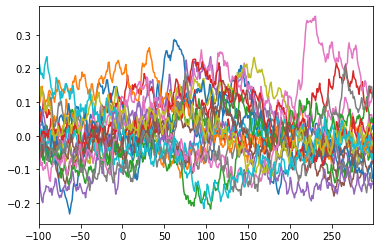

In [27]:
def one_wave_plot_tone(ch,db,frequency,trial_num,csv_path):
    #提示音の名前とchを入れると指定回分の波形を２次元配列で返す。
    #one_wave_list:2次元配列,10回分の波形,sec_axis:X軸-pre[ms]~post[ms]
    specified_num_list = csv_event_tone(csv_path,db,frequency)
    Event_stamp_sec = Event_stamp_raw - Data[str_fp(ch)+"_ts"][0][0]#本当か?
    #イベントの遅延時間補正
    one_wave_list = []
    wave_ch = Data[str_fp(ch)]
    pre_num = sec_to_num(pre)
    post_num = sec_to_num(post)
    sec_axis = [i for i in range(-pre_num,post_num)]
    for i,l in enumerate(specified_num_list):
        new_event_time = Event_stamp_sec[l]
        new_event_time_num = sec_to_num(new_event_time)
        one_wave_data = td_array(wave_ch[new_event_time_num-pre_num:new_event_time_num+post_num])
        one_wave_list.append(one_wave_data)
        plt.plot(sec_axis,one_wave_data)#デバッグ
        if(i == trial_num-1):break
    one_wave_np = np.array(one_wave_list)
    #returnにどこがトリガーか入れる?
one_wave_plot_tone(14,70,8000,20,csv_path)

In [34]:
def multi_wave_plot(ch,db,frequency,trial_num,csv_path):
    #trial_num回(例えば10回)加算平均したものを返す
    one_wave_np,sec_axis = one_wave_tone(ch,db,frequency,trial_num,csv_path)
    if(len(one_wave_np) < trial_num):
        print("試行回数が指定より不足しています")#エラー文
    else:
        weight_average = one_wave_np[0]
        for i in range(int(trial_num)):
            if(i == 0):pass#初期化対策
            else:weight_average = weight_average + one_wave_np[i]
            
        weight_average = weight_average /  int(trial_num)
        return weight_average,sec_axis
weight_average,sec_axis = multi_wave_plot("Flat_49_537.5_0.3.npy",7,10)

TypeError: multi_wave_plot() missing 2 required positional arguments: 'trial_num' and 'csv_path'

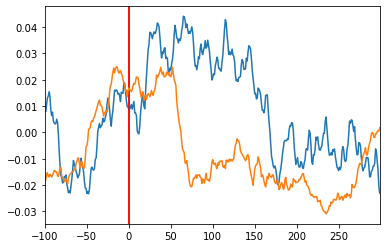

In [33]:
def multi_wave_plot_tone(ch,db,frequency,trial_num,csv_path):
    #trial_num回(例えば10回)加算平均したものを返す
    one_wave_np,sec_axis = one_wave_tone(ch,db,frequency,trial_num,csv_path)
    if(len(one_wave_np) < trial_num):
        print("試行回数が指定より不足しています")#エラー文
    else:
        weight_average = one_wave_np[0]
        for i in range(int(trial_num)):
            if(i == 0):pass#初期化対策
            else:weight_average = weight_average + one_wave_np[i]
            
        weight_average = weight_average /  int(trial_num)
        plt.axvline(x=0, color='r')
        plt.plot(sec_axis,weight_average)
        return weight_average,sec_axis
weight_average,sec_axis= multi_wave_plot_tone(14,70,8000,20,csv_path)
weight_average,sec_axis= multi_wave_plot_tone(10,50,32000,20,csv_path)